# Анализ пространственных данных. Домашнее задание №2

Мягкий дедлайн: __4 ноября 2020 г. 23:59__

Жесткий дедлайн (со штрафом в _50%_ от количества набранных вами за ДЗ баллов): __5 ноября 2020 г. 08:59__

Визуализация "чего-либо" __без__ выполненного основного задания оценивается в __0 баллов__

ФИО: `Латыпов Ильяс Дамирович`

Группа: `MADE-DS-12`

## Задание №1. Горячая точка (алгоритм - 10 баллов, визуализация - 10 баллов).

Генерируйте рандомные точки на планете Земля до тех пор, пока не попадете на территорию ``Афганистана``

1. Вы можете использовать функции принадлжености точки полигону и расстояния от точки до полигона (в метрах)
2. Предложите не наивный алгоритм поиска (генерировать __напрямую__ точку из полигона границ Афганистана __запрещено__)

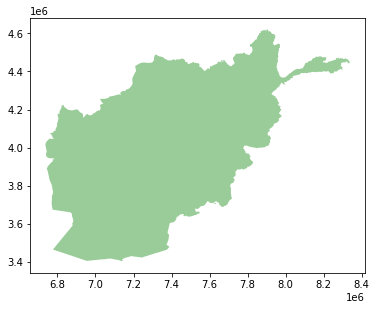

In [1]:
# Загрузка полигона границ Афганистан
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import osmnx as ox
afg_polygon = ox.geocode_to_gdf('Afganistan')
afg_polygon = afg_polygon.to_crs('epsg:3395')
afg_polygon.plot(color='green', alpha=0.4, figsize=(6,7));

In [2]:
# минимизация расстояния до полигона границ Афганистана с нулевым начальным приближением
from scipy import optimize
path = []
def dist(x, path):
    path.append(x)
    return afg_polygon.distance(Point(x)).values[0]

decision = optimize.minimize(lambda x: dist(x, path), [0, 0], method='SLSQP')
print(decision)
print("Проверка содержания найденной точки в полигоне границ Афганистана:", afg_polygon.contains(Point(decision.x)).values[0])

     fun: 0.0
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 43
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([7613476.39786402, 3853157.71885312])
Проверка содержания найденной точки в полигоне границ Афганистана: True


**Визуализируйте пошагово предложенный алгоритм при помощи ``Folium``**

In [3]:
import folium
#Перевод пути в долготу и широту (формат folium) и его визуализация
df_path = gpd.GeoDataFrame({'geometry': [Point(xy )for xy in path]},
                          columns = ['geometry'], geometry='geometry', crs = "epsg:3395")
df_path = df_path.to_crs('epsg:4326')
path_follium = [[y, x] for x, y in zip(df_path['geometry'].x.to_list(), df_path['geometry'].y.to_list())]


world_map = folium.Map(
    location = path_follium[-1],
    zoom_start = 3,
    tiles = 'Stamen Terrain'
)
for marker in path_follium[1:-1]:
    folium.Marker(location = marker, icon = folium.Icon(color='orange')).add_to(world_map)
folium.Marker(location = path_follium[0], icon = folium.Icon(color='red')).add_to(world_map)
folium.Marker(location = path_follium[-1], icon = folium.Icon(color='green')).add_to(world_map)
world_map

## Задание №2. Качество жизни (20 баллов).

Для измерения показателя качества жизни в точке, найденной в предыдущем задании, вам необходимо рассчитать следующую сумму расстояний (в метрах):

1. Расстояние от точки до 5 ближайших __*__ банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости
2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице
3. Расстояние от точки до 5 ближайших кинотеатров, наодящихся в стране с самым большим отношением числа железнодорожных станций к автобусным остановкам в южной части __**__

__*__ При поиске _N_ ближайших объектов обязательно использовать ``R-tree``

__**__ Южной частью страны является территория, находящаяся к югу от множества точек, равноудаленных от самой северной и самой южной точек страны

In [4]:
# определение стран у которых areaId заканчивается на 0 на датасета 'naturalearth_lowres' geopandas
from OSMPythonTools.nominatim import Nominatim
nominatim = Nominatim()

countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
country_list = countries["name"].to_list()
wrong_name_list = ['Dem. Rep. Congo', 'Dominican Rep.', 'Central African Rep.', 'Eq. Guinea', 
                   'Solomon Is.', 'N. Cyprus', 'Bosnia and Herz.']
for wrong_name in wrong_name_list:
    country_list.remove(wrong_name)
country_list.extend(['DR Congo', 'Dominican Republic', 'Central African Republic', 'Guinea', 
                     'Solomon Islands', 'Cyprus', 'Bosnia and Herzegovina'])    
  
country_list_filtr = []
for country in country_list:
    areaId = nominatim.query(country).areaId()
    if areaId is None:
        print("None :", country)
        continue
    if areaId % 10 == 0:
        country_list_filtr.append([areaId, country])
        print(areaId, country)   

3600195270 Tanzania
3600196240 Uzbekistan
3602978650 Norway
3600059470 Brazil
3600287670 Honduras
3600192830 Cameroon
3600192780 Liberia
3600195290 Malawi
3600088210 eSwatini
3600184640 Bangladesh
3600184840 Syria
3600079510 Estonia
3600295480 Portugal
3600080500 Australia
3600364110 Azerbaijan
3602103120 Brunei
3600192800 Ethiopia
3602088990 Kosovo
3600192790 Central African Republic


In [5]:
# определение стран у которых id заканчивается на 0 на основе запроса данных с OSM
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
overpass = Overpass()
result = overpass.query('relation["admin_level"="2"][boundary=administrative];out;')

country_list_filtr_dop = []
for item in result.elements():
    if item.id() % 10 == 0:
        country_list_filtr_dop.append([item.id(), item.tag('name:en')])
        print(item.id(), item.tag('name:en'))

59470 Brazil
79510 Estonia
80500 Australia
88210 Eswatini
90340 France - Luxembourg
126410 France - Andorra
184640 Bangladesh
184840 Syria
192780 Liberia
192790 Central African Republic
192800 Ethiopia
192830 Cameroon
195270 Tanzania
195290 Malawi
196240 Uzbekistan
287670 Honduras
295480 Portugal
364110 Azerbaijan
449220 Taiwan
535790 Comoros
535880 São Tomé and Príncipe
536780 Singapore
536900 Antigua and Barbuda
2088990 Kosovo
2103120 Brunei
2186600 Tokelau
2978650 Norway


## Задание №3. Поездка по Нью-Йорку (маршрут - 20 баллов, визуализация - 10 баллов).

Добраться __на автомобиле__ от входа в ``Central Park`` __Нью-Йорка__ (со стороны ``5th Avenue``) до пересечения ``Water Street`` и ``Washington Street`` в Бруклине (откуда получаются лучшие фото Манхэттенского моста) довольно непросто - разумеется, из-за вечных пробок. Однако еще сложнее это сделать, проезжая мимо школ, где дети то и дело переходят дорогу в неположенном месте.

Вам необходимо построить описанный выше маршрут, избегая на своем пути школы. Визуализируйте данный маршрут (также добавив школы и недоступные для проезда участки дорог) при помощи ``Folium``

Данные о расположении школ Нью-Йорка можно найти [здесь](https://catalog.data.gov/dataset/2019-2020-school-point-locations)

In [6]:
# Вспомогательные функции из лекций
from pyproj import Transformer
from shapely.geometry import Polygon, mapping, MultiPolygon, LineString, Point
from openrouteservice import client
from shapely.ops import cascaded_union

# Function to create buffer around tweet point geometries
def CreateBufferPolygon(point_in, resolution=10, radius=10):    
    transformer = Transformer.from_crs('epsg:4326', 'epsg:32632', always_xy=True)
    point_in_proj = transformer.transform(*point_in) 
    point_buffer_proj = Point(point_in_proj).buffer(radius, resolution=resolution)  
    transformer = Transformer.from_crs('epsg:32632', 'epsg:4326', always_xy=True)
    poly_wgs = []
    for point in point_buffer_proj.exterior.coords:
        poly_wgs.append(transformer.transform(*point))
        
    return poly_wgs

# Function to request directions with avoided_polygon feature
def CreateRoute(avoided_point_list, n=0):
    route_request = {'coordinates': coordinates, 
                    'format_out': 'geojson',
                    'profile': 'driving-car',
                    'preference': 'shortest',
                    'instructions': False,
                     'options': {'avoid_polygons': mapping(MultiPolygon(avoided_point_list))}} 
    route_directions = clnt.directions(**route_request)
    
    return route_directions


# Function to create buffer around requested route
def CreateBuffer(route_directions): 
    line_tup = []
    for line in route_directions['features'][0]['geometry']['coordinates']:
        tup_format = tuple(line)
        line_tup.append(tup_format)  

    new_linestring = LineString(line_tup)
    dilated_route = new_linestring.buffer(0.001)
        
    return dilated_route

def style_function(color): 
    return lambda feature: dict(color=color)

In [7]:
#Загрузка данных о расположении школ 
df_school = pd.read_csv("2019_-_2020_School_Point_Locations.csv")
df_school = df_school.rename(columns={"the_geom": "geometry"})
for i in ["POINT", "(", ")"]:
    df_school.geometry = df_school.geometry.str.replace(i, "")
df_school.geometry = df_school.geometry.str.strip() 
df_school.geometry = df_school.geometry.apply(lambda x: Point(map(float, x.split(" "))))
df_school = gpd.GeoDataFrame(df_school, geometry='geometry', crs = "epsg:4326")
print(df_school.shape)
df_school.head()

(1992, 18)


,geometry,ATS_Code,Loc_Code,Loc_Name,Managed_by,LCC,PrimaryBui,BIN,BBL,Address,City,BoroNum,State,Zip,GeoDistric,AdiminDist,XCoordinat,YCoordinat
0,POINT (-73.85554 40.70843),75Q233,Q233,P.S. Q233,1,7,Q686,4447233,4.038861e+09,91-30 METROPOLITAN AVENUE,QUEENS,4,NY,11375,28,75,1024300,197410
1,POINT (-73.98867 40.76133),02M212,M212,P.S. 212 Midtown West,1,2,M017,1025092,1.010380e+09,328 WEST 48 STREET,MANHATTAN,1,NY,10036,2,2,987390,216649
2,POINT (-73.73770 40.71099),29Q034,Q034,P.S. 034 John Harvard,1,2,Q034,4240503,4.111510e+09,104-12 SPRINGFIELD BOULEVARD,QUEENS,4,NY,11429,29,29,1056968,198417
3,POINT (-73.94071 40.66181),17K091,K091,P.S. 091 The Albany Avenue School,1,2,K091,3106599,3.047940e+09,532 ALBANY AVENUE,BROOKLYN,3,NY,11203,17,17,1000700,180396
4,POINT (-74.19343 40.52815),31R455,R455,Tottenville High School,1,5,R455,5082634,5.066130e+09,100 LUTEN AVENUE,STATEN ISLAND,5,NY,10312,31,31,930477,131756


In [8]:
%%time
import warnings
warnings.filterwarnings('ignore')

#Найдем школы попадющие в целевую область
bounds_x = [-74.1, -73.92] # границы  целевой области исследования
bounds_y = [40.69, 40.85] # границы  целевой области исследования
df_school["bounds"] = df_school.geometry.apply(lambda point_: (bounds_x[0] < point_.x < bounds_x[1]) 
                         and (bounds_y[0] < point_.y < bounds_y[1])).astype("uint8")
school_follium = [[y, x] for x, y in zip(df_school[df_school["bounds"] == 1]['geometry'].x.to_list(), 
                                         df_school[df_school["bounds"] == 1]['geometry'].y.to_list())]

start_point = [-73.962328, 40.778971] # координаты начала маршрута
start_point_folium = start_point[::-1]
end_point = [-73.989593, 40.703209] # координаты конца маршрута
end_point_folium = end_point[::-1]

ny_map = folium.Map(
    location = [(end_point_folium[0] + start_point_folium[0])/2, (end_point_folium[1] + start_point_folium[1])/2],
    zoom_start = 12,
    tiles = 'Stamen Terrain' #Toner Terrain
)
folium.Marker(location = start_point_folium, icon = folium.Icon(color='orange')).add_to(ny_map) #начальная точка маршрута
folium.Marker(location = end_point_folium, icon = folium.Icon(color='green')).add_to(ny_map) #конечная точка маршрута

# Сформируем восьмиугольники вокруг координат школы с заданным радиусом, которые не должен пересекать маршрут
RADIUS = 150 # радиус восьмиугольника вокруг школы
school_polygons = []
school_geometry = []
for marker in school_follium:
    school_polygon = CreateBufferPolygon(marker[::-1], resolution=2, radius=RADIUS)
    school_polygons.append(school_polygon)
    school_geometry.append(Polygon(school_polygon))
    
union_poly = mapping(cascaded_union(school_geometry))                     
folium.features.GeoJson(data=union_poly, style_function=style_function('#ffd699'),).add_to(ny_map)
ny_map

Wall time: 58.6 s


In [9]:
# Построение маршрута без ограничений на путь и маршрут с избеганием на пути школ
with open('api_key.txt') as infile:
    api_key = infile.read()
clnt = client.Client(key=api_key)
coordinates = [start_point, end_point]

avoided_point_list = [] 
route_directions = CreateRoute(avoided_point_list) 

folium.features.GeoJson(data=route_directions,
                        style_function=style_function('#ff5050'),
                        overlay=True).add_to(ny_map)     

avoided_point_list = school_geometry
route_directions = CreateRoute(avoided_point_list, 1)
dilated_route = CreateBuffer(route_directions)
        
folium.features.GeoJson(data=route_directions,
                        style_function=style_function('#006600'),
                        overlay=True).add_to(ny_map)
ny_map.add_child(folium.map.LayerControl())
ny_map